# Comparing McQuillan and Starspot Periods

In [1]:
#tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.stats as astat
from solartwins import *
import eleanor
import pickle
import lightkurve as lk
from starspot import sigma_clipping
import starspot as ss
from lightkurve import search_targetpixelfile
from IPython.display import display, HTML, Image
import starspot.rotation_tools as rt

In [2]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=False)

# Opening saved files

In [3]:
#list of stars, target num, sector in tess with two minute cadences
with open('two_result.data', 'rb') as filehandle:
    search_result_two = pickle.load(filehandle)

#stars, target num, sector with thirty minute cadences
with open('thirty_result.data', 'rb') as filehandle:
    search_result_thirty = pickle.load(filehandle)

#names of stars with thirty minute cadences
with open('thirty_m_cadence.data', 'rb') as filehandle:
    thirty_m_cadence = pickle.load(filehandle)
    
#names of stars with two minute cadences
with open('two_m_cadence.data', 'rb') as filehandle:
    two_m_cadence = pickle.load(filehandle)

In [4]:
# opening young stars and ages data from AutoCorrelations

with open('young_stars_dict.data', 'rb') as filehandle:
    young_stars = pickle.load(filehandle) #list of two min cadence target names and sectors
    
with open('young_star_names.data', 'rb') as filehandle:
    young_star_names = pickle.load(filehandle) #list of two min cadence target names and sectors

# McQuillan Autocorrelation Function

In [5]:
# importing data from McQuillan et al 2012
with open('McQuillan_Supplementary_Data/table5.txt', 'r') as f:
    no_rotation_period_txt = f.readlines()
with open('McQuillan_Supplementary_Data/table2.txt', 'r') as f:
    m_dwarf_rotation_period_txt = f.readlines()
with open('McQuillan_Supplementary_Data/table3.txt', 'r') as f:
    giants_txt = f.readlines()
with open('McQuillan_Supplementary_Data/table4.txt', 'r') as f:
    two_periods_txt = f.readlines()

In [6]:
#converting txt files to DataFrames 
m_dwarf_rotation_period = pd.DataFrame([sub.split(",") for sub in m_dwarf_rotation_period_txt])
giants = pd.DataFrame([sub.split(",") for sub in giants_txt])
two_periods = pd.DataFrame([sub.split(",") for sub in two_periods_txt])
no_rotation_period = pd.DataFrame([sub.split(",") for sub in no_rotation_period_txt])

In [7]:
def ac_mcquillan_str_in(star, num_points, k = None): 

    mq_KID = 'KIC ' + star
    tpf_lc = search_targetpixelfile(mq_KID).download_all(quality_bitmask='default');
    
    if len(tpf_lc) > 1:
        lc_mq = tpf_lc[1].to_lightcurve(aperture_mask=tpf_lc[1].pipeline_mask).remove_outliers(sigma=5).bin(binsize=10);
    if len(tpf_lc) > 2: 
        lc_mq = tpf_lc[2].to_lightcurve(aperture_mask=tpf_lc[2].pipeline_mask).remove_outliers(sigma=5).bin(binsize=10);
    else: 
        lc_mq = tpf_lc.to_lightcurve(aperture_mask=tpf_lc.pipeline_mask).remove_outliers(sigma=5).bin(binsize=10);

    
    varied_k = [] #array of autocorrelated fluxes for a given star with varied lag time 
    flux = lc_mq.flux[0:] 
    N = len(flux)
    time = lc_mq.time[0:]
    dt = time[1] - time[0] #cadence
    
    if k is None: 
        k = np.linspace(5, (N/2), num_points, dtype = int) #lag time
    
    flux_bar = np.average(flux)
    
    #equation for McQuillan's AC function
    for i, v in enumerate(k): 
        numerator = []
        for ii in range(N - k[i]): 
            num = (flux[ii]-flux_bar)*(flux[ii + k[i]] - flux_bar)  
            numerator.append(num)
            
        denominator = []
        for jj in range(N):
            den = (flux[jj]-flux_bar)**2
            denominator.append(den)
            
        rk = (np.sum(numerator)/np.sum(denominator))
        varied_k.append(rk)
    
    tau = k * dt

    return varied_k, tau 

# Plotting Differences in Periods

In [8]:
m_dwarf_rotation_period

,0,1,2,3,4,5,6,7
0,KID,Teff,logg,Mass,Period,Period_Err,Amplitude,Flag\n
1,1162635,3899,4.62,0.5037,15.509,0.064,10.7,NF\n
2,1430893,3956,4.41,0.5260,17.144,0.046,10.4,NF\n
3,1572802,3990,4.48,0.5394,0.368,0.000,74.8,PB\n
4,1721911,3833,4.58,0.4781,28.403,0.394,3.9,NF\n
...,...,...,...,...,...,...,...,...
1566,12646841,3511,4.04,0.3583,3.300,0.030,9.79,NF\n
1567,12688834,3827,4.60,0.4758,19.289,0.087,7.7,NF\n
1568,12689979,3875,4.66,0.4943,29.772,0.516,6.2,NF\n
1569,12691684,3662,4.23,0.4132,38.824,10.378,11.2,NF\n


In [9]:
short_mq_periods = [] # list of periods less than 20 days
short_mq_KID = [] #list of KIDs of stars with periods less than 20 days

for indx, period in enumerate(m_dwarf_rotation_period[4]):
    if period <= '20.0':
        short_mq_periods.append(period)
        short_mq_KID.append(m_dwarf_rotation_period[0][indx])

In [10]:
Kep_ID = np.array(short_mq_KID[1:24])
periods = np.array(short_mq_periods[1:24])
mq_ac = periods.astype(np.float)

my_ac = []
ss_ac_array = []

In [11]:
Kep_ID = np.delete(Kep_ID, 0) #removing faulty value
Kep_ID = np.delete(Kep_ID, 17) #removing faulty value
Kep_ID = np.delete(Kep_ID, 19) 

mq_ac = np.delete(mq_ac, 0)
mq_ac = np.delete(mq_ac, 17)
mq_ac = np.delete(mq_ac, 19)

#function for obtaining starspot periods
def ss_ac(Kepler_ID):
    tess_cadence = 1./24./30.
    ss_ac_tpf = search_targetpixelfile('KIC ' + Kepler_ID).download_all(quality_bitmask='default');
    if len(ss_ac_tpf) > 1:
        lc_ss_ac = ss_ac_tpf[1].to_lightcurve(aperture_mask=ss_ac_tpf[1].pipeline_mask).remove_outliers(sigma=5).bin(binsize=10);
    if len(ss_ac_tpf) > 2: 
        lc_ss_ac = ss_ac_tpf[2].to_lightcurve(aperture_mask=ss_ac_tpf[2].pipeline_mask).remove_outliers(sigma=5).bin(binsize=10);
    else: 
        lc_ss_ac = ss_ac_tpf.to_lightcurve(aperture_mask=ss_ac_tpf.pipeline_mask).remove_outliers(sigma=5).bin(binsize=10);

    med_ss_ac = np.median(lc_ss_ac.flux)
    time_ss_ac = lc_ss_ac.time[0:]
    flux_ss_ac = lc_ss_ac.flux[0:]/med_ss_ac - 1
    yerr_ss_ac = lc_ss_ac.flux_err[0:]/med_ss_ac

    ss_ac_mask = astat.sigma_clip(flux_ss_ac, sigma=1, masked = True)
    flux_ss_ac = flux_ss_ac[~ss_ac_mask.mask]
    time_ss_ac = time_ss_ac[~ss_ac_mask.mask]
    flux_err_ss_ac = yerr_ss_ac[~ss_ac_mask.mask]

    rotate_ss_ac = ss.RotationModel(time_ss_ac, flux_ss_ac, flux_err_ss_ac)

    return rotate_ss_ac.acf_rotation(tess_cadence)

from tqdm import tqdm

for ii in tqdm(Kep_ID):
    print (ii)
    ss_ac_array.append(ss_ac(ii))

fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(Kep_ID, mq_ac, label = 'McQuillan Period', c ='purple')
#ax.scatter(Kep_ID, my_ac, label = 'My Period', c = 'forestgreen')
ax.scatter(Kep_ID, ss_ac_array, label = 'Starspot Period', c = 'orange')
ax.set_xlabel('Kepler ID')
ax.set_ylabel('Period (days)')
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')

In [12]:
tess_cadence = 1./24./30.  # This is a TESS 2 minute cadence star.

# 🌟 Comparing McQ vs Starspot results 🌟

# Young Star #1 from McQuillan dataset


The McQuillan ACF period is :  0.368


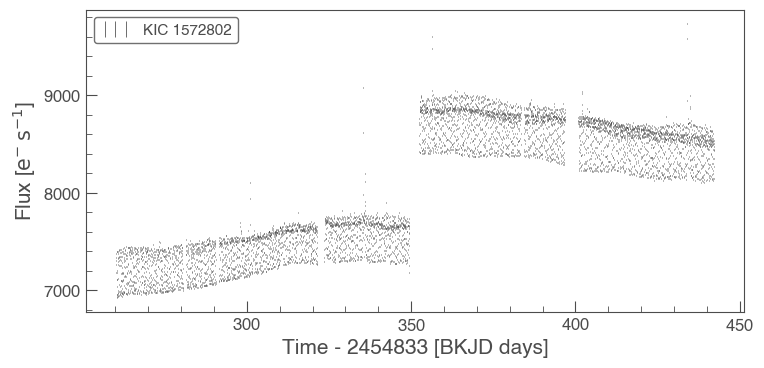

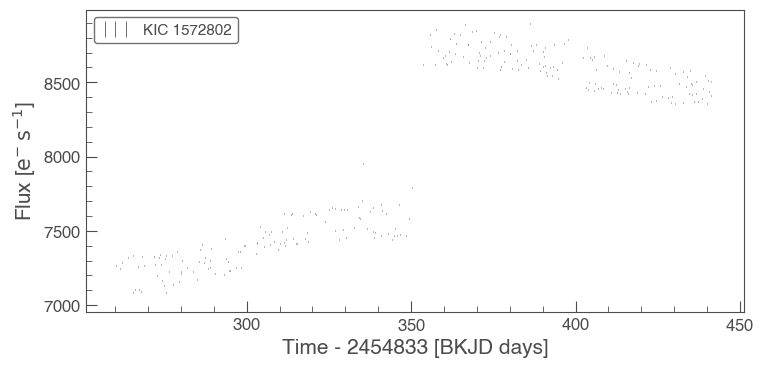

In [13]:
KID_0 = 'KIC ' + Kep_ID[0]
comp_0 = search_targetpixelfile(KID_0).download_all(quality_bitmask='default');
print('The McQuillan ACF period is : ', mq_ac[0])

lc_comp_0_1 = comp_0[2].to_lightcurve(aperture_mask=comp_0[2].pipeline_mask)
lc_comp_0_2 = comp_0[3].to_lightcurve(aperture_mask=comp_0[3].pipeline_mask)
lc_comp_0 = lc_comp_0_1.append(lc_comp_0_2)

lc_comp_0.errorbar()
lc_comp_0.remove_outliers(sigma=5).bin(binsize=10).errorbar();

In [14]:
ss_comp_0 = search_targetpixelfile(KID_0).download_all(quality_bitmask='default');
lc_0 = ss_comp_0[2].to_lightcurve(aperture_mask=ss_comp_0[2].pipeline_mask).remove_outliers(sigma=6).bin(binsize=10);

med_0 = np.median(lc_0.flux)
time_0 = lc_0.time[0:]
flux_0 = lc_0.flux[0:]/med_0 - 1
yerr_0 = lc_0.flux_err[0:]/med_0

mask_0 = astat.sigma_clip(flux_0, sigma=1, masked = True)
flux_0 = flux_0[~mask_0.mask]
time_0 = time_0[~mask_0.mask]
flux_err_0 = yerr_0[~mask_0.mask]

In [15]:
rotate_ss_0 = ss.RotationModel(time_0, flux_0, flux_err_0)

The Lomb-Scargle period is :  7.61632529955307
The ACF period is :  6.424999999999999


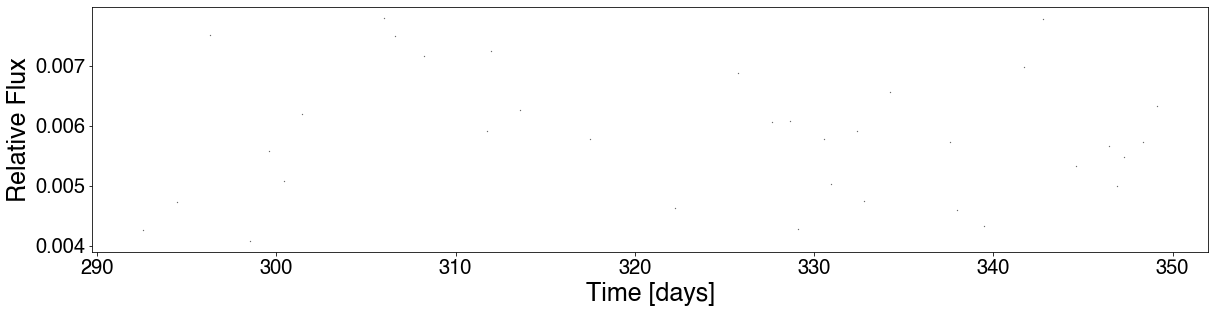

In [16]:
rotate_ss_0.lc_plot()
ls_period_comp_0 = rotate_ss_0.ls_rotation()
acf_period_comp_0 = rotate_ss_0.acf_rotation(tess_cadence)
print('The Lomb-Scargle period is : ', ls_period_comp_0)
print('The ACF period is : ', acf_period_comp_0)

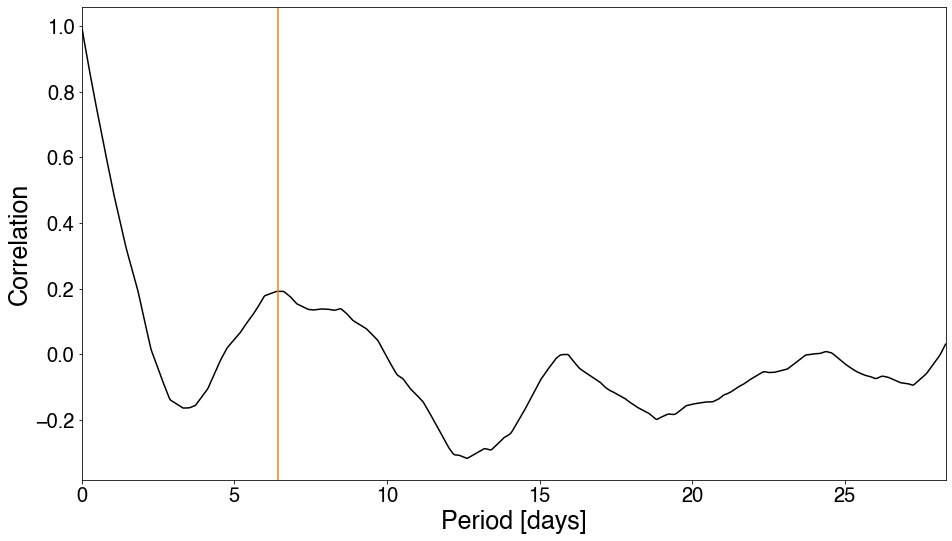

In [17]:
rotate_ss_0.acf_plot();

In [18]:
Kep_ID_0 = ac_mcquillan_str_in(Kep_ID[0], 100);

Text(0.5, 1.0, 'Autocorrelated McQ 0')

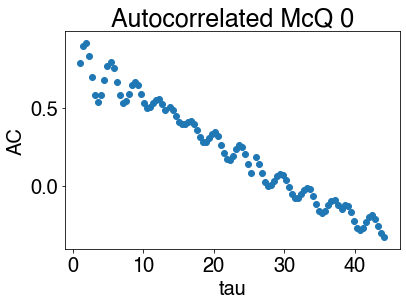

In [19]:
plt.scatter(Kep_ID_0[1], Kep_ID_0[0])
plt.xlabel('tau', fontsize = 20)
plt.ylabel('AC', fontsize = 20)
plt.title('Autocorrelated McQ 0', fontsize = 25)

# Young Star #2 from McQuillan dataset

The McQuillan ACF period is :  11.351


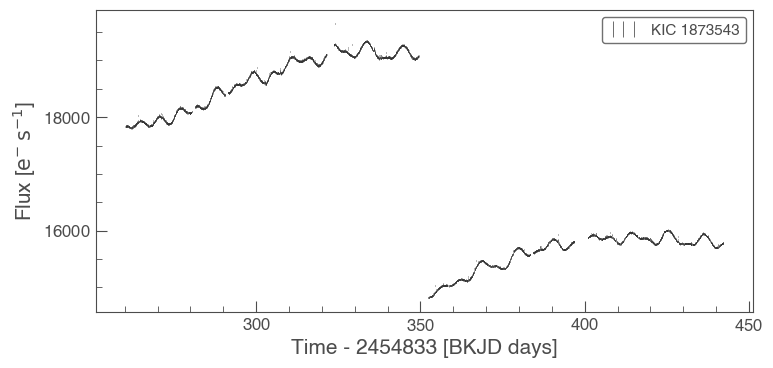

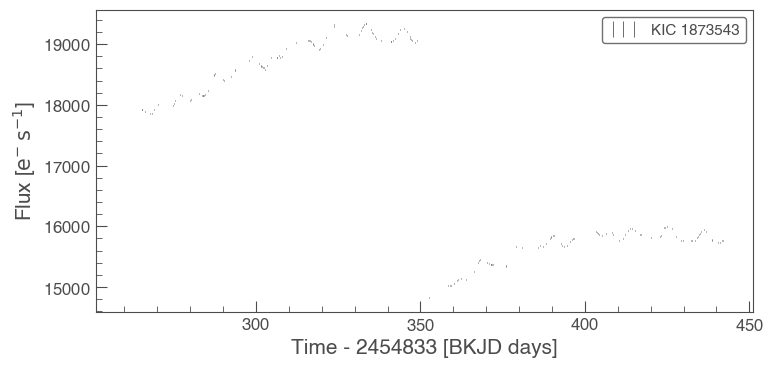

In [20]:
KID_1 = 'KIC ' + Kep_ID[1]
comp_1 = search_targetpixelfile(KID_1).download_all(quality_bitmask='default');
print('The McQuillan ACF period is : ', mq_ac[1])

lc_comp_1_1 = comp_1[2].to_lightcurve(aperture_mask=comp_1[2].pipeline_mask)
lc_comp_1_2 = comp_1[3].to_lightcurve(aperture_mask=comp_1[3].pipeline_mask)
lc_comp_1 = lc_comp_1_1.append(lc_comp_1_2)

lc_comp_1.errorbar()
lc_comp_1.remove_outliers(sigma=5).bin(binsize=10).errorbar();

In [21]:
ss_comp_1 = search_targetpixelfile(KID_1).download_all(quality_bitmask='default');
lc_1 = ss_comp_1[2].to_lightcurve(aperture_mask=ss_comp_1[2].pipeline_mask).remove_outliers(sigma=6).bin(binsize=10);

med_1 = np.median(lc_1.flux)
time_1 = lc_1.time[0:]
flux_1 = lc_1.flux[0:]/med_1 - 1
yerr_1 = lc_1.flux_err[0:]/med_1

mask_1 = astat.sigma_clip(flux_1, sigma=1, masked = True)
flux_1 = flux_1[~mask_1.mask]
time_1 = time_1[~mask_1.mask]
flux_err_1 = yerr_1[~mask_1.mask]

In [22]:
rotate_ss_1 = ss.RotationModel(time_1, flux_1, flux_err_1)

The Lomb-Scargle period is :  2.5742551318289237
The ACF period is :  4.955555555555555


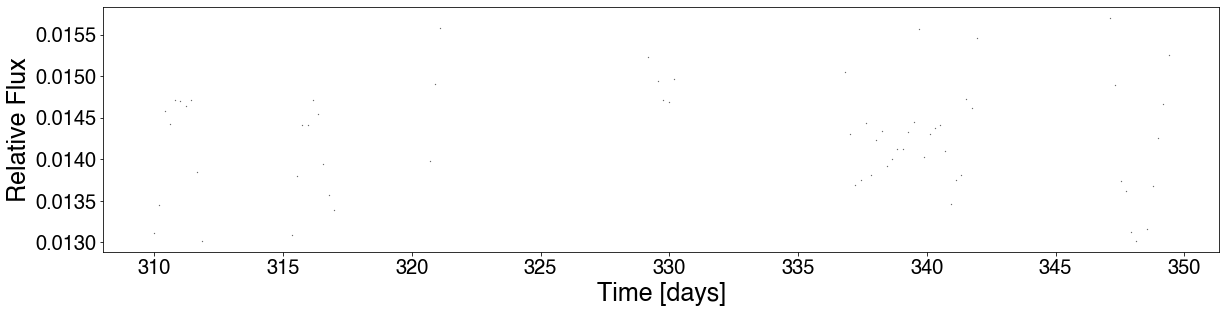

In [23]:
rotate_ss_1.lc_plot()
ls_period_comp_1 = rotate_ss_1.ls_rotation()
acf_period_comp_1 = rotate_ss_1.acf_rotation(tess_cadence)
print('The Lomb-Scargle period is : ', ls_period_comp_1)
print('The ACF period is : ', acf_period_comp_1)

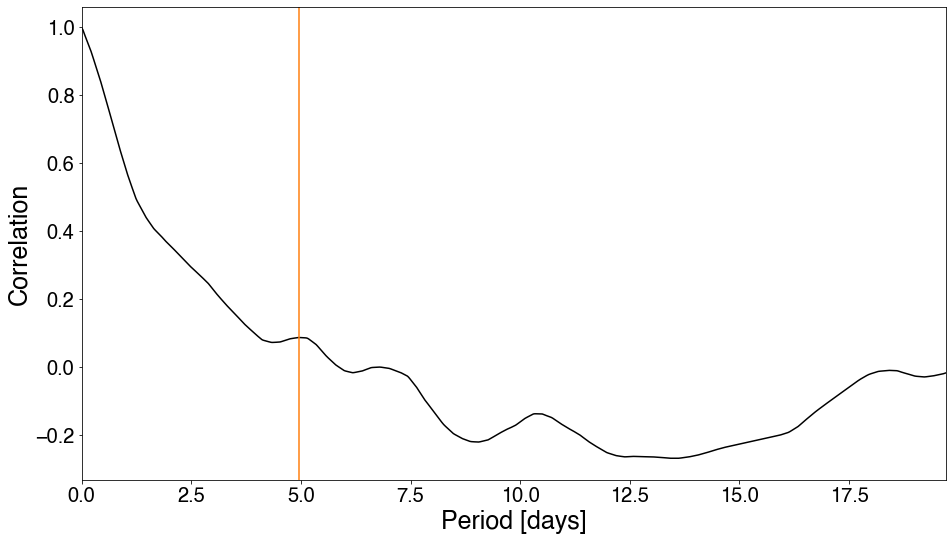

In [24]:
rotate_ss_1.acf_plot();

In [25]:
Kep_ID_1 = ac_mcquillan_str_in(Kep_ID[1], 100);

Text(0.5, 1.0, 'Autocorrelated McQ 1')

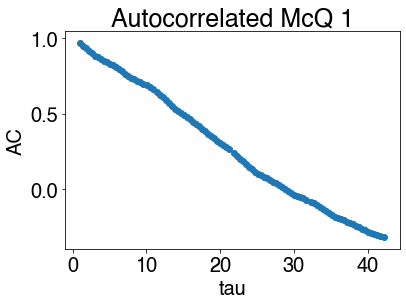

In [26]:
plt.scatter(Kep_ID_1[1], Kep_ID_1[0])
plt.xlabel('tau', fontsize = 20)
plt.ylabel('AC', fontsize = 20)
plt.title('Autocorrelated McQ 1', fontsize = 25)

# 🌟 #3

The McQuillan ACF period is : 18.646


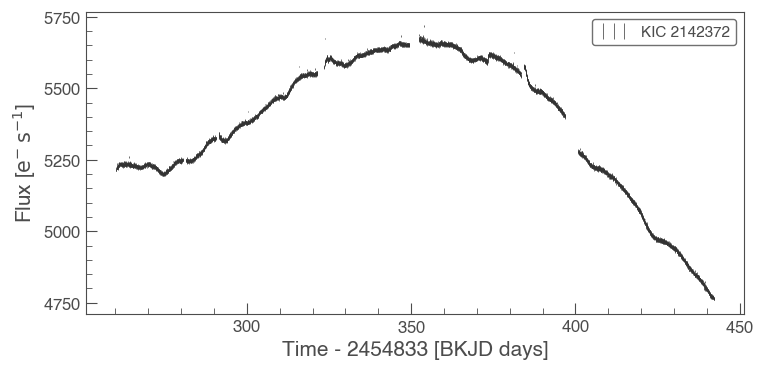

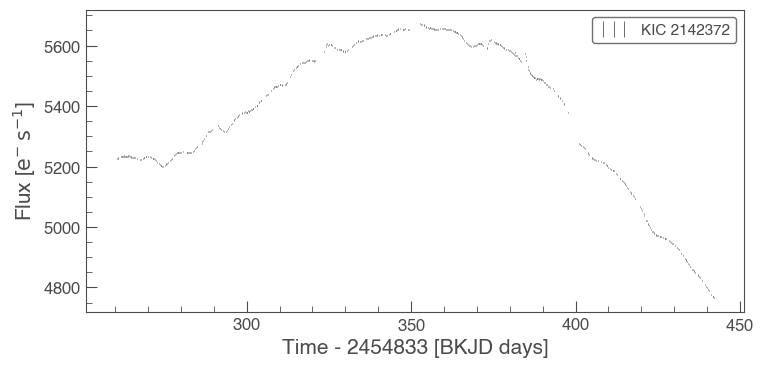

In [27]:
KID_2 = 'KIC ' + Kep_ID[2]
comp_2 = search_targetpixelfile(KID_2).download_all(quality_bitmask='default');
print('The McQuillan ACF period is :', mq_ac[2])

lc_comp_2_1 = comp_2[2].to_lightcurve(aperture_mask=comp_2[2].pipeline_mask)
lc_comp_2_2 = comp_2[3].to_lightcurve(aperture_mask=comp_2[3].pipeline_mask)
lc_comp_2 = lc_comp_2_1.append(lc_comp_2_2)

lc_comp_2.errorbar()
lc_comp_2.remove_outliers(sigma=5).bin(binsize=10).errorbar();

In [28]:
ss_comp_2 = search_targetpixelfile(KID_2).download_all(quality_bitmask='default');
lc_2 = ss_comp_2[2].to_lightcurve(aperture_mask=ss_comp_2[2].pipeline_mask).remove_outliers(sigma=6)#.bin(binsize=10);

med_2 = np.median(lc_2.flux)
time_2 = lc_2.time[0:]
flux_2 = lc_2.flux[0:]/med_2 - 1
yerr_2 = lc_2.flux_err[0:]/med_2

mask_2 = astat.sigma_clip(flux_2, sigma=1, masked = True)
flux_2 = flux_2[~mask_2.mask]
time_2 = time_2[~mask_2.mask]
flux_err_2 = yerr_2[~mask_2.mask]

In [29]:
rotate_ss_2 = ss.RotationModel(time_2, flux_2, flux_err_2)

The Lomb-Scargle period is :  15.75268664757422
The ACF period is :  0.08333333333333333


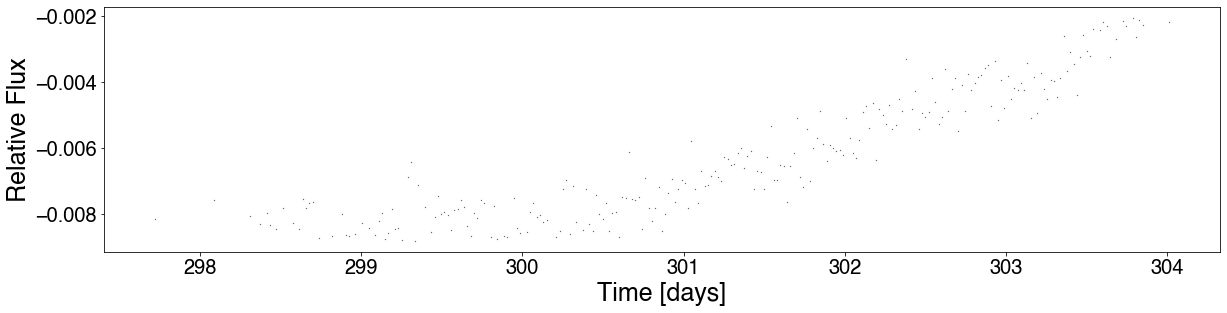

In [30]:
rotate_ss_2.lc_plot()
ls_period_comp_2 = rotate_ss_2.ls_rotation()
acf_period_comp_2 = rotate_ss_2.acf_rotation(tess_cadence)
print('The Lomb-Scargle period is : ', ls_period_comp_2)
print('The ACF period is : ', acf_period_comp_2)

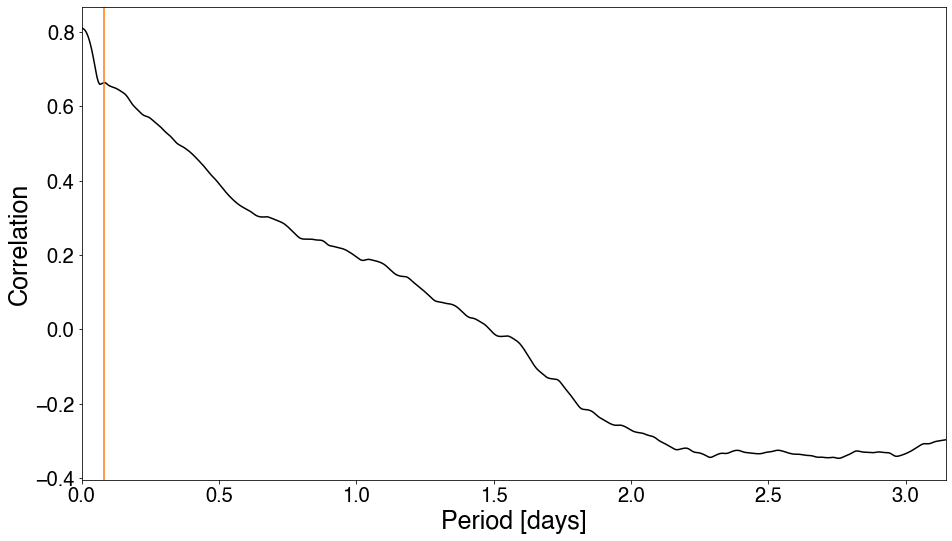

In [31]:
rotate_ss_2.acf_plot();

In [32]:
Kep_ID_2 = ac_mcquillan_str_in(Kep_ID[2], 100);

Text(0.5, 1.0, 'Autocorrelated McQ 2')

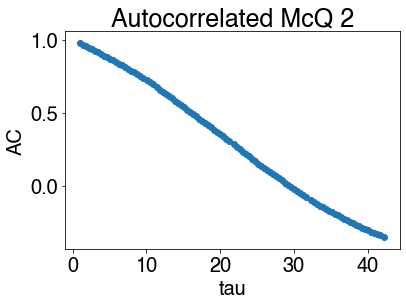

In [33]:
plt.scatter(Kep_ID_2[1], Kep_ID_2[0])
plt.xlabel('tau', fontsize = 20)
plt.ylabel('AC', fontsize = 20)
plt.title('Autocorrelated McQ 2', fontsize = 25)

# 🌟 #4

In [34]:
KID_3 = 'KIC ' + Kep_ID[3]
comp_3 = search_targetpixelfile(KID_3).download_all(quality_bitmask='default');
print('The McQuillan ACF is : ', mq_ac[3])

lc_comp_3_1 = comp_3[2].to_lightcurve(aperture_mask=comp_3[2].pipeline_mask)
lc_comp_3_2 = comp_3[3].to_lightcurve(aperture_mask=comp_3[3].pipeline_mask)
lc_comp_3 = lc_comp_3_1.append(lc_comp_3_2)

lc_comp_3.errorbar()
lc_comp_3.remove_outliers(sigma=5).bin(binsize=10).errorbar();

KeyboardInterrupt: 

In [ ]:
ss_comp_3 = search_targetpixelfile(KID_3).download_all(quality_bitmask='default');
lc_3 = ss_comp_3[2].to_lightcurve(aperture_mask=ss_comp_3[2].pipeline_mask).remove_outliers(sigma=6).bin(binsize=10);

med_3 = np.median(lc_3.flux)
time_3 = lc_3.time[0:]
flux_3 = lc_3.flux[0:]/med_3 - 1
yerr_3 = lc_3.flux_err[0:]/med_3

mask_3 = astat.sigma_clip(flux_3, sigma=1, masked = True)
flux_3 = flux_3[~mask_3.mask]
time_3 = time_3[~mask_3.mask]
flux_err_3 = yerr_3[~mask_3.mask]

In [ ]:
rotate_ss_3 = ss.RotationModel(time_3, flux_3, flux_err_3)

In [ ]:
rotate_ss_3.lc_plot()
ls_period_comp_3 = rotate_ss_3.ls_rotation()
acf_period_comp_3 = rotate_ss_3.acf_rotation(tess_cadence)
print('The Lomb-Scargle period is : ', ls_period_comp_3)
print('The ACF period is : ', acf_period_comp_3)

In [ ]:
rotate_ss_3.acf_plot();

In [ ]:
Kep_ID_3 = ac_mcquillan_str_in(Kep_ID[3], 100);

In [ ]:
plt.scatter(Kep_ID_3[1], Kep_ID_3[0])
plt.xlabel('tau', fontsize = 20)
plt.ylabel('AC', fontsize = 20)
plt.title('Autocorrelated McQ 3', fontsize = 25)

# 🌟 #5

In [ ]:
KID_4 = 'KIC ' + Kep_ID[4]
comp_4 = search_targetpixelfile(KID_4).download_all(quality_bitmask='default');
print('The McQuillan ACF is : ', mq_ac[4])

lc_comp_4_1 = comp_4[2].to_lightcurve(aperture_mask=comp_4[2].pipeline_mask)
lc_comp_4_2 = comp_4[3].to_lightcurve(aperture_mask=comp_4[3].pipeline_mask)
lc_comp_4 = lc_comp_4_1.append(lc_comp_4_2)

lc_comp_4.errorbar()
lc_comp_4.remove_outliers(sigma=5).bin(binsize=10).errorbar();

In [ ]:
ss_comp_4 = search_targetpixelfile(KID_4).download_all(quality_bitmask='default');
lc_4 = ss_comp_4[3].to_lightcurve(aperture_mask=ss_comp_4[3].pipeline_mask).remove_outliers(sigma=6).bin(binsize=10);

med_4 = np.median(lc_4.flux)
time_4 = lc_4.time[0:]
flux_4 = lc_4.flux[0:]/med_4 - 1
yerr_4 = lc_4.flux_err[0:]/med_4

mask_4 = astat.sigma_clip(flux_4, sigma=1, masked = True)
flux_4 = flux_4[~mask_4.mask]
time_4 = time_4[~mask_4.mask]
flux_err_4 = yerr_4[~mask_4.mask]

In [ ]:
rotate_ss_4 = ss.RotationModel(time_4, flux_4, flux_err_4)

In [ ]:
rotate_ss_4.lc_plot()
ls_period_comp_4 = rotate_ss_4.ls_rotation()
acf_period_comp_4 = rotate_ss_4.acf_rotation(tess_cadence)
print('The Lomb-Scargle period is : ', ls_period_comp_4)
print('The ACF period is : ', acf_period_comp_4)

In [ ]:
rotate_ss_4.acf_plot();

In [ ]:
Kep_ID_4 = ac_mcquillan_str_in(Kep_ID[4], 100);

In [ ]:
plt.scatter(Kep_ID_4[1], Kep_ID_4[0])
plt.xlabel('tau', fontsize = 20)
plt.ylabel('AC', fontsize = 20)
plt.title('Autocorrelated McQ 4', fontsize = 25)

# 🌟 #6

In [ ]:
KID_5 = 'KIC ' + Kep_ID[5]
comp_5 = search_targetpixelfile(KID_5).download_all(quality_bitmask='default');
print('The McQuillan ACF is : ', mq_ac[5])

lc_comp_5_1 = comp_5[2].to_lightcurve(aperture_mask=comp_5[2].pipeline_mask)
lc_comp_5_2 = comp_5[3].to_lightcurve(aperture_mask=comp_5[3].pipeline_mask)
lc_comp_5 = lc_comp_5_1.append(lc_comp_5_2)

lc_comp_5.errorbar()
lc_comp_5.remove_outliers(sigma=5).bin(binsize=10).errorbar();

In [ ]:
ss_comp_5 = search_targetpixelfile(KID_5).download_all(quality_bitmask='default');
lc_5 = ss_comp_5[2].to_lightcurve(aperture_mask=ss_comp_5[2].pipeline_mask).remove_outliers(sigma=6).bin(binsize=10);

med_5 = np.median(lc_5.flux)
time_5 = lc_5.time[0:]
flux_5 = lc_5.flux[0:]/med_5 - 1
yerr_5 = lc_5.flux_err[0:]/med_5

mask_5 = astat.sigma_clip(flux_5, sigma=1, masked = True)
flux_5 = flux_5[~mask_5.mask]
time_5 = time_5[~mask_5.mask]
flux_err_5 = yerr_5[~mask_5.mask]

In [ ]:
rotate_ss_5 = ss.RotationModel(time_5, flux_5, flux_err_5)

In [ ]:
rotate_ss_5.lc_plot()
ls_period_comp_5 = rotate_ss_5.ls_rotation()
acf_period_comp_5 = rotate_ss_5.acf_rotation(tess_cadence)
print('The Lomb-Scargle period is : ', ls_period_comp_5)
print('The ACF period is : ', acf_period_comp_5)

In [ ]:
rotate_ss_5.acf_plot();

In [ ]:
Kep_ID_5 = ac_mcquillan_str_in(Kep_ID[5], 100);

In [ ]:
plt.scatter(Kep_ID_5[1], Kep_ID_5[0])
plt.xlabel('tau', fontsize = 20)
plt.ylabel('AC', fontsize = 20)
plt.title('Autocorrelated McQ 5', fontsize = 25)

# 🌟 #7

In [ ]:
KID_6 = 'KIC ' + Kep_ID[6]
comp_6 = search_targetpixelfile(KID_6).download_all(quality_bitmask='default');
print('The McQuillan ACF is : ', mq_ac[6])

lc_comp_6_1 = comp_6[2].to_lightcurve(aperture_mask=comp_6[2].pipeline_mask)
lc_comp_6_2 = comp_6[3].to_lightcurve(aperture_mask=comp_6[3].pipeline_mask)
lc_comp_6 = lc_comp_6_1.append(lc_comp_6_2)

lc_comp_6.errorbar()
lc_comp_6.remove_outliers(sigma=5).bin(binsize=10).errorbar();

In [ ]:
ss_comp_6 = search_targetpixelfile(KID_6).download_all(quality_bitmask='default');
lc_6 = ss_comp_6[2].to_lightcurve(aperture_mask=ss_comp_6[2].pipeline_mask).remove_outliers(sigma=6).bin(binsize=10);

med_6 = np.median(lc_6.flux)
time_6 = lc_6.time[0:]
flux_6 = lc_6.flux[0:]/med_6 - 1
yerr_6 = lc_6.flux_err[0:]/med_6

mask_6 = astat.sigma_clip(flux_6, sigma=1, masked = True)
flux_6 = flux_6[~mask_6.mask]
time_6 = time_6[~mask_6.mask]
flux_err_6 = yerr_6[~mask_6.mask]

In [ ]:
rotate_ss_6 = ss.RotationModel(time_6, flux_6, flux_err_6)

In [ ]:
rotate_ss_6.lc_plot()
ls_period_comp_6 = rotate_ss_6.ls_rotation()
acf_period_comp_6 = rotate_ss_6.acf_rotation(tess_cadence)
print('The Lomb-Scargle period is : ', ls_period_comp_6)
print('The ACF period is : ', acf_period_comp_6)

In [ ]:
rotate_ss_6.acf_plot();

In [ ]:
Kep_ID_6 = ac_mcquillan_str_in(Kep_ID[6], 100);

In [ ]:
plt.scatter(Kep_ID_6[1], Kep_ID_6[0])
plt.xlabel('tau', fontsize = 20)
plt.ylabel('AC', fontsize = 20)
plt.title('Autocorrelated McQ 6', fontsize = 25)

# 🌟 #8

In [ ]:
KID_7 = 'KIC ' + Kep_ID[7]
comp_7 = search_targetpixelfile(KID_7).download_all(quality_bitmask='default');
print('The McQuillan ACF is : ', mq_ac[7])

lc_comp_7_1 = comp_7[2].to_lightcurve(aperture_mask=comp_7[2].pipeline_mask)
lc_comp_7_2 = comp_7[3].to_lightcurve(aperture_mask=comp_7[3].pipeline_mask)
lc_comp_7 = lc_comp_7_1.append(lc_comp_7_2)

lc_comp_7.errorbar()
lc_comp_7.remove_outliers(sigma=5).bin(binsize=10).errorbar();

In [ ]:
ss_comp_7 = search_targetpixelfile(KID_7).download_all(quality_bitmask='default');
lc_7 = ss_comp_7[2].to_lightcurve(aperture_mask=ss_comp_7[2].pipeline_mask).remove_outliers(sigma=6).bin(binsize=10);

med_7 = np.median(lc_7.flux)
time_7 = lc_7.time[0:]
flux_7 = lc_7.flux[0:]/med_7 - 1
yerr_7 = lc_7.flux_err[0:]/med_7

mask_7 = astat.sigma_clip(flux_7, sigma=1, masked = True)
flux_7 = flux_7[~mask_7.mask]
time_7 = time_7[~mask_7.mask]
flux_err_7 = yerr_7[~mask_7.mask]

In [ ]:
rotate_ss_7 = ss.RotationModel(time_7, flux_7, flux_err_7)

In [ ]:
rotate_ss_7.lc_plot()
ls_period_comp_7 = rotate_ss_7.ls_rotation()
acf_period_comp_7 = rotate_ss_7.acf_rotation(tess_cadence)
print('The Lomb-Scargle period is : ', ls_period_comp_7)
print('The ACF period is : ', acf_period_comp_7)

In [ ]:
rotate_ss_7.acf_plot();

In [ ]:
Kep_ID_7 = ac_mcquillan_str_in(Kep_ID[7], 100);

In [ ]:
plt.scatter(Kep_ID_7[1], Kep_ID_7[0])
plt.xlabel('tau', fontsize = 20)
plt.ylabel('AC', fontsize = 20)
plt.title('Autocorrelated McQ 7', fontsize = 25)

# 🌟 #9

In [ ]:
KID_8 = 'KIC ' + Kep_ID[8]
comp_8 = search_targetpixelfile(KID_8).download_all(quality_bitmask='default');
print('The McQuillan ACF is : ', mq_ac[8])

lc_comp_8_1 = comp_8[2].to_lightcurve(aperture_mask=comp_8[2].pipeline_mask)
lc_comp_8_2 = comp_8[3].to_lightcurve(aperture_mask=comp_8[3].pipeline_mask)
lc_comp_8 = lc_comp_8_1.append(lc_comp_8_2)

lc_comp_8.errorbar()
lc_comp_8.remove_outliers(sigma=5).bin(binsize=10).errorbar();

In [ ]:
ss_comp_8 = search_targetpixelfile(KID_8).download_all(quality_bitmask='default');
lc_8 = ss_comp_8[3].to_lightcurve(aperture_mask=ss_comp_8[3].pipeline_mask).remove_outliers(sigma=6).bin(binsize=10);

med_8 = np.median(lc_8.flux)
time_8 = lc_8.time[0:]
flux_8 = lc_8.flux[0:]/med_8 - 1
yerr_8 = lc_8.flux_err[0:]/med_8

mask_8 = astat.sigma_clip(flux_8, sigma=1, masked = True)
flux_8 = flux_8[~mask_8.mask]
time_8 = time_8[~mask_8.mask]
flux_err_8 = yerr_8[~mask_8.mask]

In [ ]:
rotate_ss_8 = ss.RotationModel(time_8, flux_8, flux_err_8)

In [ ]:
rotate_ss_8.lc_plot()
ls_period_comp_8 = rotate_ss_8.ls_rotation()
acf_period_comp_8 = rotate_ss_8.acf_rotation(tess_cadence)
print('The Lomb-Scargle period is : ', ls_period_comp_8)
print('The ACF period is : ', acf_period_comp_8)

In [ ]:
rotate_ss_8.acf_plot();

In [ ]:
Kep_ID_8 = ac_mcquillan_str_in(Kep_ID[8], 100);

In [ ]:
plt.scatter(Kep_ID_8[1], Kep_ID_8[0])
plt.xlabel('tau', fontsize = 20)
plt.ylabel('AC', fontsize = 20)
plt.title('Autocorrelated McQ 8', fontsize = 25)

# 🌟 #10

In [ ]:
KID_9 = 'KIC ' + Kep_ID[9]
comp_9 = search_targetpixelfile(KID_9).download_all(quality_bitmask='default');
print('The McQuillan ACF is : ', mq_ac[9])

lc_comp_9_1 = comp_9[2].to_lightcurve(aperture_mask=comp_9[2].pipeline_mask)
lc_comp_9_2 = comp_9[3].to_lightcurve(aperture_mask=comp_9[3].pipeline_mask)
lc_comp_9 = lc_comp_9_1.append(lc_comp_9_2)

lc_comp_9.errorbar()
lc_comp_9.remove_outliers(sigma=5).bin(binsize=10).errorbar();

In [ ]:
ss_comp_9 = search_targetpixelfile(KID_9).download_all(quality_bitmask='default');
lc_9 = ss_comp_9[2].to_lightcurve(aperture_mask=ss_comp_9[2].pipeline_mask).remove_outliers(sigma=6).bin(binsize=10);

med_9 = np.median(lc_9.flux)
time_9 = lc_9.time[0:]
flux_9 = lc_9.flux[0:]/med_9 - 1
yerr_9 = lc_9.flux_err[0:]/med_9

mask_9 = astat.sigma_clip(flux_9, sigma=1, masked = True)
flux_9 = flux_9[~mask_9.mask]
time_9 = time_9[~mask_9.mask]
flux_err_9 = yerr_9[~mask_9.mask]

In [ ]:
rotate_ss_9 = ss.RotationModel(time_9, flux_9, flux_err_9)

In [ ]:
rotate_ss_9.lc_plot()
ls_period_comp_9 = rotate_ss_9.ls_rotation()
acf_period_comp_9 = rotate_ss_9.acf_rotation(tess_cadence)
print('The Lomb-Scargle period is : ', ls_period_comp_9)
print('The ACF period is : ', acf_period_comp_9)

In [ ]:
rotate_ss_9.acf_plot();

In [ ]:
Kep_ID_9 = ac_mcquillan_str_in(Kep_ID[9], 100);

In [ ]:
plt.scatter(Kep_ID_9[1], Kep_ID_9[0])
plt.xlabel('tau', fontsize = 20)
plt.ylabel('AC', fontsize = 20)
plt.title('Autocorrelated McQ 9', fontsize = 25)

# 🌟 #11

In [ ]:
KID_10 = 'KIC ' + Kep_ID[10]
comp_10 = search_targetpixelfile(KID_10).download_all(quality_bitmask='default');
print('The McQuillan ACF is : ', mq_ac[10])

lc_comp_10_1 = comp_10[2].to_lightcurve(aperture_mask=comp_10[2].pipeline_mask)
lc_comp_10_2 = comp_10[3].to_lightcurve(aperture_mask=comp_10[3].pipeline_mask)
lc_comp_10 = lc_comp_10_1.append(lc_comp_10_2)

lc_comp_10.errorbar()
lc_comp_10.remove_outliers(sigma=5).bin(binsize=10).errorbar();

In [ ]:
ss_comp_10 = search_targetpixelfile(KID_10).download_all(quality_bitmask='default');
lc_10 = ss_comp_10[2].to_lightcurve(aperture_mask=ss_comp_10[2].pipeline_mask).remove_outliers(sigma=6).bin(binsize=10);

med_10 = np.median(lc_10.flux)
time_10 = lc_10.time[0:]
flux_10 = lc_10.flux[0:]/med_10 - 1
yerr_10 = lc_10.flux_err[0:]/med_10

mask_10 = astat.sigma_clip(flux_10, sigma=1, masked = True)
flux_10 = flux_10[~mask_10.mask]
time_10 = time_10[~mask_10.mask]
flux_err_10 = yerr_10[~mask_10.mask]

In [ ]:
rotate_ss_10 = ss.RotationModel(time_10, flux_10, flux_err_10)

In [ ]:
rotate_ss_10.lc_plot()
ls_period_comp_10 = rotate_ss_10.ls_rotation()
acf_period_comp_10 = rotate_ss_10.acf_rotation(tess_cadence)
print('The Lomb-Scargle period is : ', ls_period_comp_10)
print('The ACF period is : ', acf_period_comp_10)

In [ ]:
rotate_ss_10.acf_plot();

In [ ]:
Kep_ID_10 = ac_mcquillan_str_in(Kep_ID[10], 100);

In [ ]:
plt.scatter(Kep_ID_10[1], Kep_ID_10[0])
plt.xlabel('tau', fontsize = 20)
plt.ylabel('AC', fontsize = 20)
plt.title('Autocorrelated McQ 10', fontsize = 25)

# 🌟 #12

In [ ]:
KID_11 = 'KIC ' + Kep_ID[11]
comp_11 = search_targetpixelfile(KID_11).download_all(quality_bitmask='default');
print('The McQuillan ACF is : ', mq_ac[11])

lc_comp_11_1 = comp_11[2].to_lightcurve(aperture_mask=comp_11[2].pipeline_mask)
lc_comp_11_2 = comp_11[3].to_lightcurve(aperture_mask=comp_11[3].pipeline_mask)
lc_comp_11 = lc_comp_11_1.append(lc_comp_11_2)

lc_comp_11.errorbar()
lc_comp_11.remove_outliers(sigma=5).bin(binsize=10).errorbar();

In [ ]:
ss_comp_11 = search_targetpixelfile(KID_11).download_all(quality_bitmask='default');
lc_11 = ss_comp_11[2].to_lightcurve(aperture_mask=ss_comp_11[2].pipeline_mask).remove_outliers(sigma=6).bin(binsize=10);

med_11 = np.median(lc_11.flux)
time_11 = lc_11.time[0:]
flux_11 = lc_11.flux[0:]/med_11 - 1
yerr_11 = lc_11.flux_err[0:]/med_11

mask_11 = astat.sigma_clip(flux_11, sigma=1, masked = True)
flux_11 = flux_11[~mask_11.mask]
time_11 = time_11[~mask_11.mask]
flux_err_11 = yerr_11[~mask_11.mask]

In [ ]:
rotate_ss_11 = ss.RotationModel(time_11, flux_11, flux_err_11)

In [ ]:
rotate_ss_11.lc_plot()
ls_period_comp_11 = rotate_ss_11.ls_rotation()
acf_period_comp_11 = rotate_ss_11.acf_rotation(tess_cadence)
print('The Lomb-Scargle period is : ', ls_period_comp_11)
print('The ACF period is : ', acf_period_comp_11)

In [ ]:
rotate_ss_11.acf_plot();

In [ ]:
Kep_ID_11 = ac_mcquillan_str_in(Kep_ID[11], 100);

In [ ]:
plt.scatter(Kep_ID_11[1], Kep_ID_11[0])
plt.xlabel('tau', fontsize = 20)
plt.ylabel('AC', fontsize = 20)
plt.title('Autocorrelated McQ 11', fontsize = 25)

# 🌟 #13

In [ ]:
KID_12 = 'KIC ' + Kep_ID[12]
comp_12 = search_targetpixelfile(KID_12).download_all(quality_bitmask='default');
print('The McQuillan ACF is : ', mq_ac[12])

lc_comp_12_1 = comp_12[2].to_lightcurve(aperture_mask=comp_12[2].pipeline_mask)
lc_comp_12_2 = comp_12[3].to_lightcurve(aperture_mask=comp_12[3].pipeline_mask)
lc_comp_12 = lc_comp_12_1.append(lc_comp_12_2)

lc_comp_12.errorbar()
lc_comp_12.remove_outliers(sigma=5).bin(binsize=10).errorbar();

In [ ]:
ss_comp_12 = search_targetpixelfile(KID_12).download_all(quality_bitmask='default');
lc_12 = ss_comp_12[2].to_lightcurve(aperture_mask=ss_comp_12[2].pipeline_mask).remove_outliers(sigma=6).bin(binsize=10);

med_12 = np.median(lc_12.flux)
time_12 = lc_12.time[0:]
flux_12 = lc_12.flux[0:]/med_12 - 1
yerr_12 = lc_12.flux_err[0:]/med_12

mask_12 = astat.sigma_clip(flux_12, sigma=1, masked = True)
flux_12 = flux_12[~mask_12.mask]
time_12 = time_12[~mask_12.mask]
flux_err_12 = yerr_12[~mask_12.mask]

In [ ]:
rotate_ss_12 = ss.RotationModel(time_12, flux_12, flux_err_12)

In [ ]:
rotate_ss_12.lc_plot()
ls_period_comp_12 = rotate_ss_12.ls_rotation()
acf_period_comp_12 = rotate_ss_12.acf_rotation(tess_cadence)
print('The Lomb-Scargle period is : ', ls_period_comp_12)
print('The ACF period is : ', acf_period_comp_12)

In [ ]:
rotate_ss_12.acf_plot();

In [ ]:
Kep_ID_12 = ac_mcquillan_str_in(Kep_ID[12], 100);

In [ ]:
plt.scatter(Kep_ID_12[1], Kep_ID_12[0])
plt.xlabel('tau', fontsize = 20)
plt.ylabel('AC', fontsize = 20)
plt.title('Autocorrelated McQ 12', fontsize = 25)

# 🌟 #14

In [ ]:
KID_13 = 'KIC ' + Kep_ID[13]
comp_13 = search_targetpixelfile(KID_13).download_all(quality_bitmask='default');
print('The McQuillan ACF is : ', mq_ac[13])

lc_comp_13_1 = comp_13[2].to_lightcurve(aperture_mask=comp_13[2].pipeline_mask)
lc_comp_13_2 = comp_13[3].to_lightcurve(aperture_mask=comp_13[3].pipeline_mask)
lc_comp_13 = lc_comp_13_1.append(lc_comp_13_2)

lc_comp_13.errorbar()
lc_comp_13.remove_outliers(sigma=5).bin(binsize=10).errorbar();

In [ ]:
ss_comp_13 = search_targetpixelfile(KID_13).download_all(quality_bitmask='default');
lc_13 = ss_comp_13[2].to_lightcurve(aperture_mask=ss_comp_13[2].pipeline_mask).remove_outliers(sigma=6).bin(binsize=10);

med_13 = np.median(lc_13.flux)
time_13 = lc_13.time[0:]
flux_13 = lc_13.flux[0:]/med_13 - 1
yerr_13 = lc_13.flux_err[0:]/med_13

mask_13 = astat.sigma_clip(flux_13, sigma=1, masked = True)
flux_13 = flux_13[~mask_13.mask]
time_13 = time_13[~mask_13.mask]
flux_err_13 = yerr_13[~mask_13.mask]

In [ ]:
rotate_ss_13 = ss.RotationModel(time_13, flux_13, flux_err_13)

In [ ]:
rotate_ss_13.lc_plot()
ls_period_comp_13 = rotate_ss_13.ls_rotation()
acf_period_comp_13 = rotate_ss_13.acf_rotation(tess_cadence)
print('The Lomb-Scargle period is : ', ls_period_comp_13)
print('The ACF period is : ', acf_period_comp_13)

In [ ]:
rotate_ss_13.acf_plot();

In [ ]:
Kep_ID_13 = ac_mcquillan_str_in(Kep_ID[13], 100);

In [ ]:
plt.scatter(Kep_ID_13[1], Kep_ID_13[0])
plt.xlabel('tau', fontsize = 20)
plt.ylabel('AC', fontsize = 20)
plt.title('Autocorrelated McQ 13', fontsize = 25)

# 🌟 #15

In [ ]:
KID_14 = 'KIC ' + Kep_ID[14]
comp_14 = search_targetpixelfile(KID_14).download_all(quality_bitmask='default');
print('The McQuillan ACF is : ', mq_ac[14])

lc_comp_14_1 = comp_14[2].to_lightcurve(aperture_mask=comp_14[2].pipeline_mask)
lc_comp_14_2 = comp_14[3].to_lightcurve(aperture_mask=comp_14[3].pipeline_mask)
lc_comp_14 = lc_comp_14_1.append(lc_comp_14_2)

lc_comp_14.errorbar()
lc_comp_14.remove_outliers(sigma=5).bin(binsize=10).errorbar();

In [ ]:
ss_comp_14 = search_targetpixelfile(KID_14).download_all(quality_bitmask='default');
lc_14 = ss_comp_14[2].to_lightcurve(aperture_mask=ss_comp_14[2].pipeline_mask).remove_outliers(sigma=6).bin(binsize=10);

med_14 = np.median(lc_14.flux)
time_14 = lc_14.time[0:]
flux_14 = lc_14.flux[0:]/med_14 - 1
yerr_14 = lc_14.flux_err[0:]/med_14

mask_14 = astat.sigma_clip(flux_14, sigma=1, masked = True)
flux_14 = flux_14[~mask_14.mask]
time_14 = time_14[~mask_14.mask]
flux_err_14 = yerr_14[~mask_14.mask]

In [ ]:
rotate_ss_14 = ss.RotationModel(time_14, flux_14, flux_err_14)

In [ ]:
rotate_ss_14.lc_plot()
ls_period_comp_14 = rotate_ss_14.ls_rotation()
acf_period_comp_14 = rotate_ss_14.acf_rotation(tess_cadence)
print('The Lomb-Scargle period is : ', ls_period_comp_14)
print('The ACF period is : ', acf_period_comp_14)

In [ ]:
rotate_ss_14.acf_plot();

In [ ]:
Kep_ID_14 = ac_mcquillan_str_in(Kep_ID[14], 100);

In [ ]:
plt.scatter(Kep_ID_14[1], Kep_ID_14[0])
plt.xlabel('tau', fontsize = 20)
plt.ylabel('AC', fontsize = 20)
plt.title('Autocorrelated McQ 14', fontsize = 25)

# 🌟 #16

In [ ]:
KID_15 = 'KIC ' + Kep_ID[15]
comp_15 = search_targetpixelfile(KID_15).download_all(quality_bitmask='default');
print('The McQuillan ACF is : ', mq_ac[15])

lc_comp_15_1 = comp_15[2].to_lightcurve(aperture_mask=comp_15[2].pipeline_mask)
lc_comp_15_2 = comp_15[3].to_lightcurve(aperture_mask=comp_15[3].pipeline_mask)
lc_comp_15 = lc_comp_15_1.append(lc_comp_15_2)

lc_comp_15.errorbar()
lc_comp_15.remove_outliers(sigma=5).bin(binsize=10).errorbar();

In [ ]:
ss_comp_15 = search_targetpixelfile(KID_15).download_all(quality_bitmask='default');
lc_15 = ss_comp_15[2].to_lightcurve(aperture_mask=ss_comp_15[2].pipeline_mask).remove_outliers(sigma=6).bin(binsize=10);

med_15 = np.median(lc_15.flux)
time_15 = lc_15.time[0:]
flux_15 = lc_15.flux[0:]/med_15 - 1
yerr_15 = lc_15.flux_err[0:]/med_15

mask_15 = astat.sigma_clip(flux_15, sigma=1, masked = True)
flux_15 = flux_15[~mask_15.mask]
time_15 = time_15[~mask_15.mask]
flux_err_15 = yerr_15[~mask_15.mask]

In [ ]:
rotate_ss_15 = ss.RotationModel(time_15, flux_15, flux_err_15)

In [ ]:
rotate_ss_15.lc_plot()
ls_period_comp_15 = rotate_ss_15.ls_rotation()
acf_period_comp_15 = rotate_ss_15.acf_rotation(tess_cadence)
print('The Lomb-Scargle period is : ', ls_period_comp_15)
print('The ACF period is : ', acf_period_comp_15)

rotate_ss_15.acf_plot();

In [ ]:
Kep_ID_15 = ac_mcquillan_str_in(Kep_ID[15], 100);

In [ ]:
plt.scatter(Kep_ID_15[1], Kep_ID_15[0])
plt.xlabel('tau', fontsize = 20)
plt.ylabel('AC', fontsize = 20)
plt.title('Autocorrelated McQ 16', fontsize = 25)

# 🌟 #17

In [ ]:
KID_16 = 'KIC ' + Kep_ID[16]
comp_16 = search_targetpixelfile(KID_16).download_all(quality_bitmask='default');
print('The McQuillan ACF is : ', mq_ac[16])

lc_comp_16_1 = comp_16[2].to_lightcurve(aperture_mask=comp_16[2].pipeline_mask)
lc_comp_16_2 = comp_16[3].to_lightcurve(aperture_mask=comp_16[3].pipeline_mask)
lc_comp_16 = lc_comp_16_1.append(lc_comp_16_2)

lc_comp_16.errorbar()
lc_comp_16.remove_outliers(sigma=5).bin(binsize=10).errorbar();

In [ ]:
ss_comp_16 = search_targetpixelfile(KID_16).download_all(quality_bitmask='default');
lc_16 = ss_comp_16[2].to_lightcurve(aperture_mask=ss_comp_16[2].pipeline_mask).remove_outliers(sigma=6).bin(binsize=10);

med_16 = np.median(lc_16.flux)
time_16 = lc_16.time[0:]
flux_16 = lc_16.flux[0:]/med_16 - 1
yerr_16 = lc_16.flux_err[0:]/med_16

mask_16 = astat.sigma_clip(flux_16, sigma=1, masked = True)
flux_16 = flux_16[~mask_16.mask]
time_16 = time_16[~mask_16.mask]
flux_err_16 = yerr_16[~mask_16.mask]

In [ ]:
rotate_ss_16 = ss.RotationModel(time_16, flux_16, flux_err_16)

In [ ]:
rotate_ss_16.lc_plot()
ls_period_comp_16 = rotate_ss_16.ls_rotation()
acf_period_comp_16 = rotate_ss_16.acf_rotation(tess_cadence)
print('The Lomb-Scargle period is : ', ls_period_comp_16)
print('The ACF period is : ', acf_period_comp_16)

rotate_ss_16.acf_plot();

In [ ]:
Kep_ID_16 = ac_mcquillan_str_in(Kep_ID[16], 100);

In [ ]:
plt.scatter(Kep_ID_16[1], Kep_ID_16[0])
plt.xlabel('tau', fontsize = 20)
plt.ylabel('AC', fontsize = 20)
plt.title('Autocorrelated McQ 16', fontsize = 25)

# 🌟 #18

In [ ]:
KID_17 = 'KIC ' + Kep_ID[17]
comp_17 = search_targetpixelfile(KID_17).download_all(quality_bitmask='default');
print('The McQuillan ACF is : ', mq_ac[17])

lc_comp_17_1 = comp_17[2].to_lightcurve(aperture_mask=comp_17[2].pipeline_mask)
lc_comp_17_2 = comp_17[3].to_lightcurve(aperture_mask=comp_17[3].pipeline_mask)
lc_comp_17 = lc_comp_17_1.append(lc_comp_17_2)

lc_comp_17.errorbar()
lc_comp_17.remove_outliers(sigma=5).bin(binsize=10).errorbar();

In [ ]:
ss_comp_17 = search_targetpixelfile(KID_17).download_all(quality_bitmask='default');
lc_17 = ss_comp_17[2].to_lightcurve(aperture_mask=ss_comp_17[2].pipeline_mask).remove_outliers(sigma=6).bin(binsize=10);

med_17 = np.median(lc_17.flux)
time_17 = lc_17.time[0:]
flux_17 = lc_17.flux[0:]/med_17 - 1
yerr_17 = lc_17.flux_err[0:]/med_17

mask_17 = astat.sigma_clip(flux_17, sigma=1, masked = True)
flux_17 = flux_17[~mask_17.mask]
time_17 = time_17[~mask_17.mask]
flux_err_17 = yerr_17[~mask_17.mask]

In [ ]:
rotate_ss_17 = ss.RotationModel(time_17, flux_17, flux_err_17)

In [ ]:
rotate_ss_17.lc_plot()
ls_period_comp_17 = rotate_ss_17.ls_rotation()
acf_period_comp_17 = rotate_ss_17.acf_rotation(tess_cadence)
print('The Lomb-Scargle period is : ', ls_period_comp_17)
print('The ACF period is : ', acf_period_comp_17)

rotate_ss_17.acf_plot();

In [ ]:
Kep_ID_17 = ac_mcquillan_str_in(Kep_ID[17], 100);

In [ ]:
plt.scatter(Kep_ID_17[1], Kep_ID_17[0])
plt.xlabel('tau', fontsize = 20)
plt.ylabel('AC', fontsize = 20)
plt.title('Autocorrelated McQ 17', fontsize = 25)

# 🌟 #19

In [ ]:
KID_18 = 'KIC ' + Kep_ID[18]
comp_18 = search_targetpixelfile(KID_18).download_all(quality_bitmask='default');
print('The McQuillan ACF is : ', mq_ac[18])

lc_comp_18_1 = comp_18[2].to_lightcurve(aperture_mask=comp_18[2].pipeline_mask)
lc_comp_18_2 = comp_18[3].to_lightcurve(aperture_mask=comp_18[3].pipeline_mask)
lc_comp_18 = lc_comp_18_1.append(lc_comp_18_2)

lc_comp_18.errorbar()
lc_comp_18.remove_outliers(sigma=5).bin(binsize=10).errorbar();

In [ ]:
ss_comp_18 = search_targetpixelfile(KID_18).download_all(quality_bitmask='default');
lc_18 = ss_comp_18[2].to_lightcurve(aperture_mask=ss_comp_18[2].pipeline_mask).remove_outliers(sigma=6).bin(binsize=10);

med_18 = np.median(lc_18.flux)
time_18 = lc_18.time[0:]
flux_18 = lc_18.flux[0:]/med_18 - 1
yerr_18 = lc_18.flux_err[0:]/med_18

mask_18 = astat.sigma_clip(flux_18, sigma=1, masked = True)
flux_18 = flux_18[~mask_18.mask]
time_18 = time_18[~mask_18.mask]
flux_err_18 = yerr_18[~mask_18.mask]

In [ ]:
rotate_ss_18 = ss.RotationModel(time_18, flux_18, flux_err_18)

In [ ]:
rotate_ss_18.lc_plot()
ls_period_comp_18 = rotate_ss_18.ls_rotation()
acf_period_comp_18 = rotate_ss_18.acf_rotation(tess_cadence)
print('The Lomb-Scargle period is : ', ls_period_comp_18)
print('The ACF period is : ', acf_period_comp_18)

rotate_ss_18.acf_plot();

In [ ]:
Kep_ID_18 = ac_mcquillan_str_in(Kep_ID[18], 100);

In [ ]:
plt.scatter(Kep_ID_18[1], Kep_ID_18[0])
plt.xlabel('tau', fontsize = 20)
plt.ylabel('AC', fontsize = 20)
plt.title('Autocorrelated McQ 18', fontsize = 25)

# 🌟 #20

In [ ]:
KID_19 = 'KIC ' + Kep_ID[19]
comp_19 = search_targetpixelfile(KID_19).download_all(quality_bitmask='default');
print('The McQuillan ACF is : ', mq_ac[19])

lc_comp_19_1 = comp_19[2].to_lightcurve(aperture_mask=comp_19[2].pipeline_mask)
lc_comp_19_2 = comp_19[3].to_lightcurve(aperture_mask=comp_19[3].pipeline_mask)
lc_comp_19 = lc_comp_19_1.append(lc_comp_19_2)

lc_comp_19.errorbar()
lc_comp_19.remove_outliers(sigma=5).bin(binsize=10).errorbar();

In [ ]:
ss_comp_19 = search_targetpixelfile(KID_19).download_all(quality_bitmask='default');
lc_19 = ss_comp_19[2].to_lightcurve(aperture_mask=ss_comp_19[2].pipeline_mask).remove_outliers(sigma=6).bin(binsize=10);

med_19 = np.median(lc_19.flux)
time_19 = lc_19.time[0:]
flux_19 = lc_19.flux[0:]/med_19 - 1
yerr_19 = lc_19.flux_err[0:]/med_19

mask_19 = astat.sigma_clip(flux_19, sigma=3, masked = True)
flux_19 = flux_19[~mask_19.mask]
time_19 = time_19[~mask_19.mask]
flux_err_19 = yerr_19[~mask_19.mask]

In [ ]:
rotate_ss_19 = ss.RotationModel(time_19, flux_19, flux_err_19)

In [ ]:
rotate_ss_19.lc_plot()
ls_period_comp_19 = rotate_ss_19.ls_rotation()
acf_period_comp_19 = rotate_ss_19.acf_rotation(tess_cadence)
print('The Lomb-Scargle period is : ', ls_period_comp_19)
print('The ACF period is : ', acf_period_comp_19)

rotate_ss_19.acf_plot();

In [ ]:
Kep_ID_19 = ac_mcquillan_str_in(Kep_ID[19], 100);

In [ ]:
plt.scatter(Kep_ID_19[1], Kep_ID_19[0])
plt.xlabel('tau', fontsize = 20)
plt.ylabel('AC', fontsize = 20)
plt.title('Autocorrelated McQ 19', fontsize = 25)